#### Import required libraries

In [233]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#### Data loading and Pre processing

In [234]:
# path = '/kaggle/input/semantic-drone-dataset/dataset/semantic_drone_dataset/'
path = '/home/don/Git/aerial-semantic-segmentation/dataset_here/dataset/semantic_drone_dataset/'

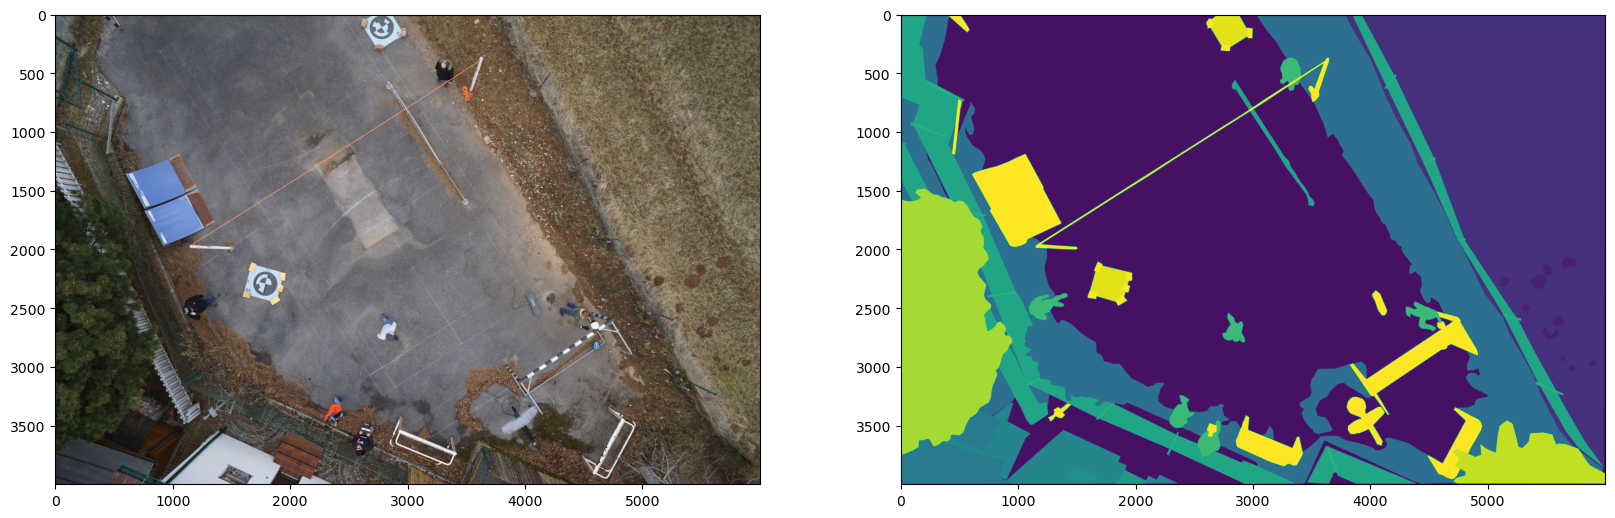

In [235]:
img = cv2.imread(path + 'original_images/001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask_test = cv2.imread(path + 'label_images_semantic/001.png', cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(mask_test)

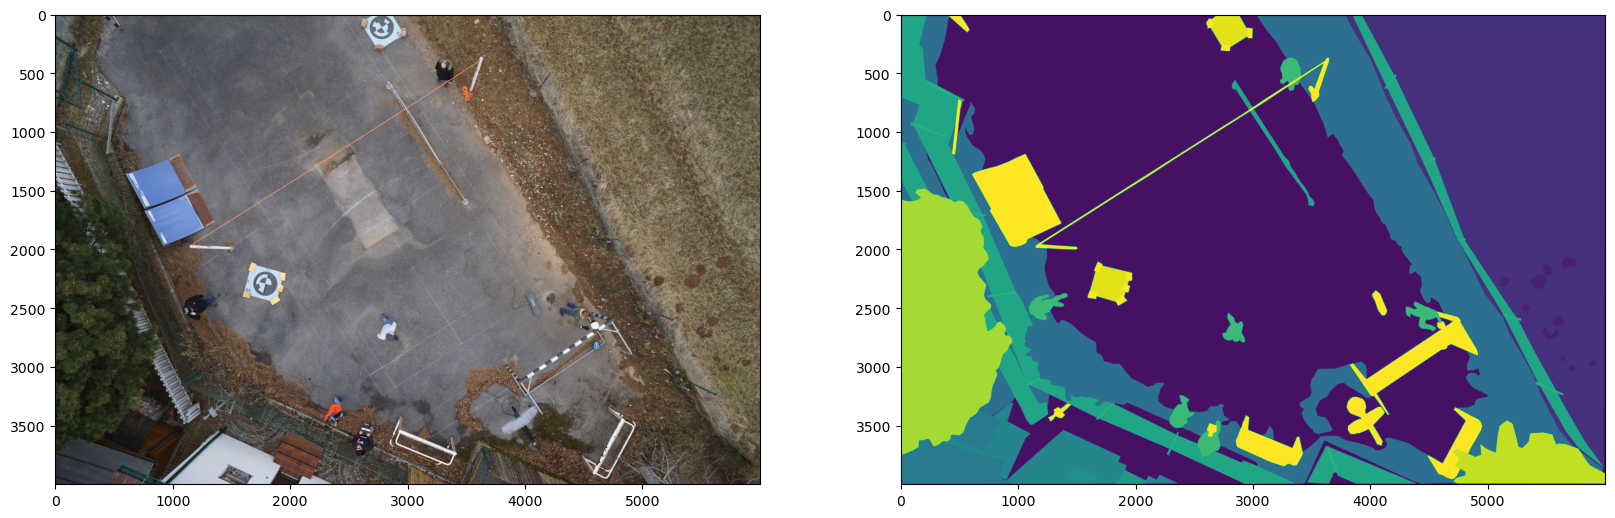

In [236]:
img = cv2.imread(path + 'original_images/001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path + 'label_images_semantic/001.png', cv2.IMREAD_GRAYSCALE)
#mask = mask.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(mask)

In [237]:
print('Image Dimensions are: ', img.shape)
print('Label Dimensions are: ', mask.shape)

Image Dimensions are:  (4000, 6000, 3)
Label Dimensions are:  (4000, 6000)


In [238]:
X = []
for filename in sorted(os.listdir(path + 'original_images/')):
    a = cv2.imread(path + 'original_images/' + filename)
    a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    a = cv2.resize(a, (128, 96))
    a = a / 255
    X.append(a)
    
X = np.array(X)

# Prepare the Labels
Y = []
for filename in sorted(os.listdir(path + 'label_images_semantic/')):
    a = cv2.imread(path + 'label_images_semantic/' + filename, cv2.IMREAD_GRAYSCALE)
    a = cv2.resize(a, (128, 96))
    #a = a / 255
    Y.append(a)
    
Y = np.array(Y)
#print(Y)
Yc = Y

(400, 96, 128, 3)
(400, 96, 128)


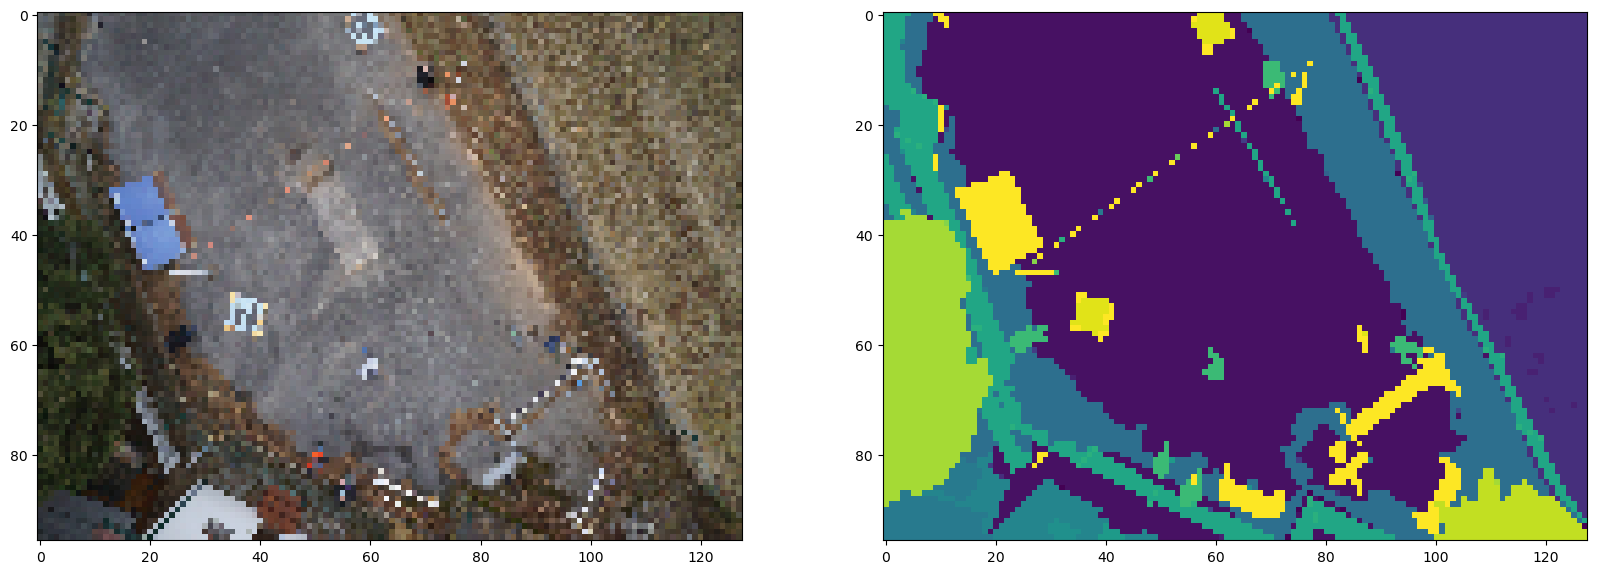

In [239]:
print(X.shape)
print(Y.shape)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(X[1])
axs[1].imshow(Y[1])

(400, 96, 128, 3)
(400, 96, 128)


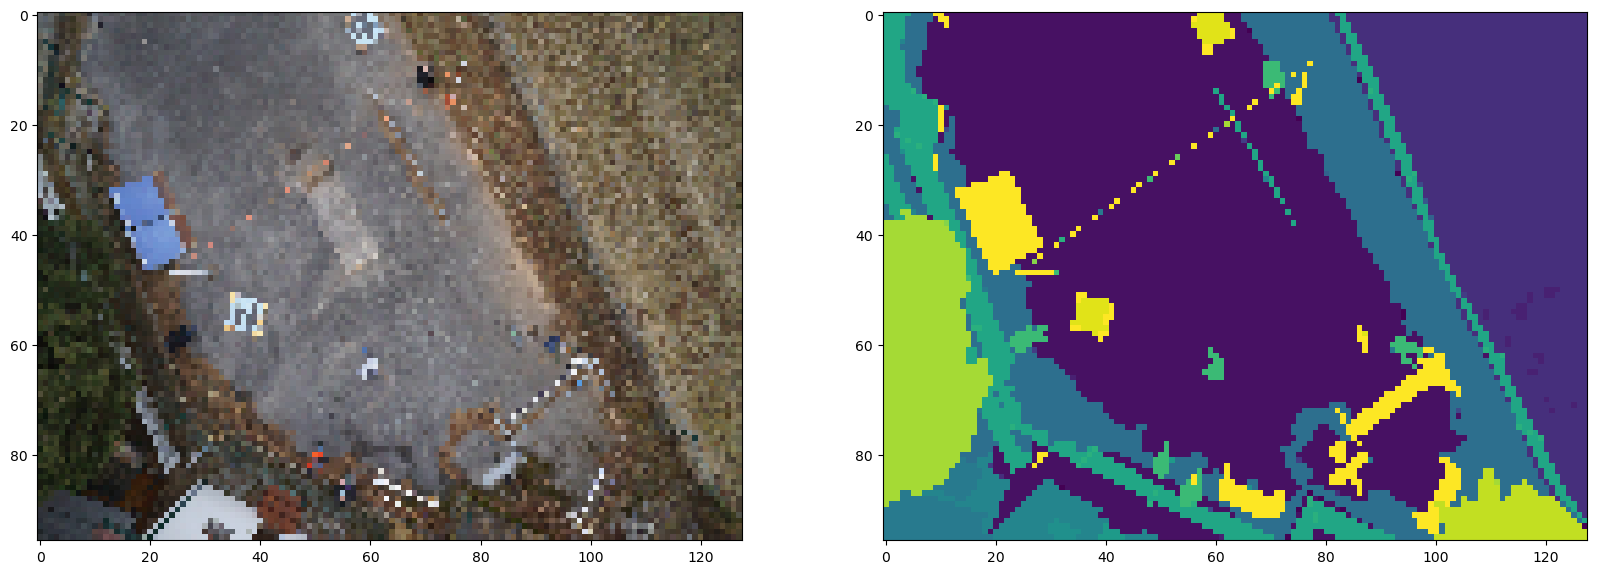

In [240]:
print(X.shape)
print(Y.shape)
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(X[1])
axs[1].imshow(Y[1])

In [241]:
test_image1 = X[-1]
test_label1 = Yc[-1]
test_image2 = X[-2]
test_label2 = Yc[-2]
x_train, x_val, y_train, y_val = train_test_split(X[0:-2], Yc[0:-2], test_size = 0.1)

In [242]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(test_label1.shape)
print(test_label2.shape)

(358, 96, 128, 3)
(358, 96, 128)
(40, 96, 128, 3)
(40, 96, 128)
(96, 128)
(96, 128)


#### Define the model and layers

In [243]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [244]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    #contracting path
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 4*n_filters)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.3) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.3, max_pooling=None)     
    
    #expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)
    
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model


img_height = 96*2
img_width = 128*2
num_channels = 3

# unet = unet_model((img_height, img_width, num_channels))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 96, 128, 32)  896         ['input_2[0][0]']                
                                                                                                  
 conv2d_21 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_20[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_21[0][0]']        

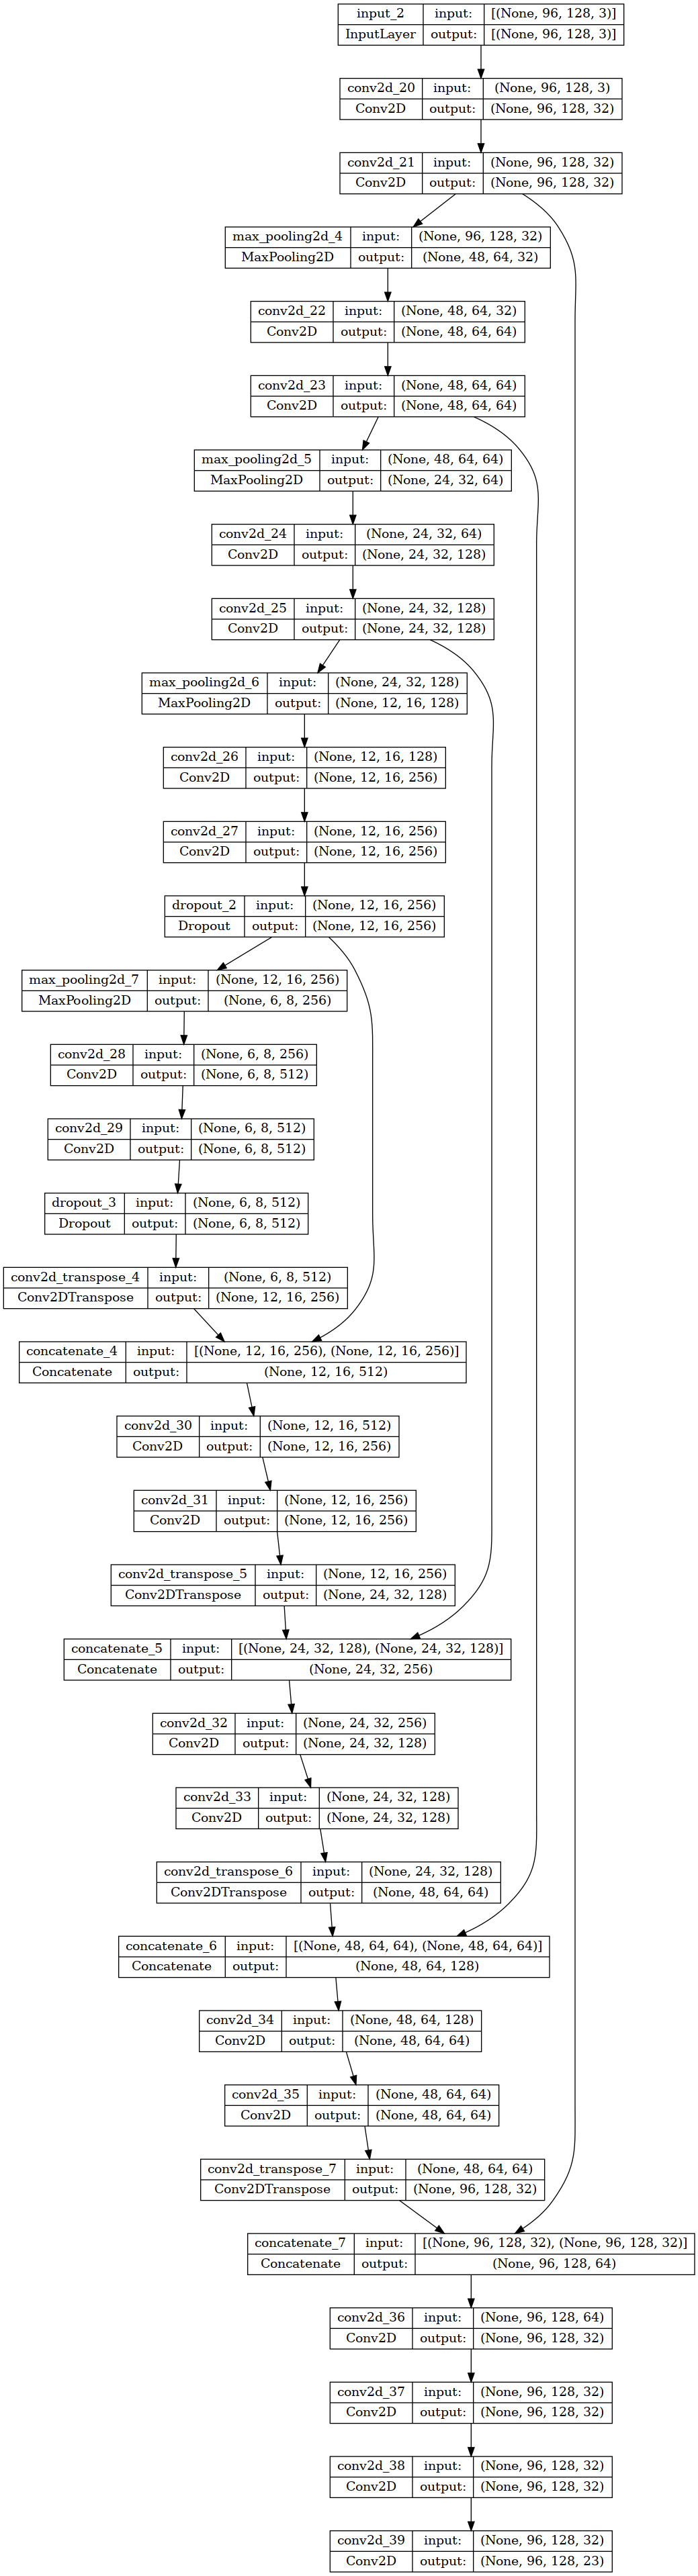

In [245]:
unet.summary()

keras.utils.plot_model(unet, show_shapes=True)

#### Additonal parameters for the model and training

In [246]:
model_checkpoint = ModelCheckpoint('unet_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True)
model_earlyStopping = EarlyStopping(min_delta= 0.001, patience=50)

In [247]:
def display(display_list):
    plt.figure(figsize=(20, 20))

    try:
    
        title = ['Input Image', 'True Mask', 'Predicted Mask',]

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()
        
    except:
    
        title = ['Input Image 1', 'True Mask 1', 'Predicted Mask 1', 'Input Image 2', 'True Mask 2', 'Predicted Mask 2']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis('off')
        plt.show()

In [248]:
def create_mask(pred_mask):
    pred_mask = tf.where(pred_mask > 0.5,1,0)
#     pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [249]:
import random
train_testing_id = random.randint(0, len(x_train))

In [250]:
def show_predictions(x_train = x_train, y_train = y_train, num=1):
    #try:
    pred_mask = unet.predict(np.expand_dims(x_train[train_testing_id], 0))
    pred_mask = np.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[0]
    display([x_train[train_testing_id], y_train[train_testing_id], pred_mask])

In [251]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
    
    def on_epoch_end(self, epoch, logs=None):
#         clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

#### Compile the model

In [252]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [253]:
display_cb = DisplayCallback()

In [254]:
history = unet.fit(x=x_train, y=y_train,
              validation_data=(x_val, y_val),
              batch_size=32, epochs=20,
              callbacks=[model_checkpoint, model_earlyStopping, display_cb])

Epoch 1/20
12/12 [==============================] - ETA: 0s - loss: 0.8860 - accuracy: 0.7704
Epoch 1: val_loss improved from inf to 0.72512, saving model to unet_model.hdf5
12/12 [==============================] - 13s 912ms/step - loss: 0.8860 - accuracy: 0.7704 - val_loss: 0.7251 - val_accuracy: 0.7861
Epoch 2/20
12/12 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.8138
Epoch 2: val_loss improved from 0.72512 to 0.58421, saving model to unet_model.hdf5
12/12 [==============================] - 12s 1s/step - loss: 0.6276 - accuracy: 0.8138 - val_loss: 0.5842 - val_accuracy: 0.8180
Epoch 3/20
12/12 [==============================] - ETA: 0s - loss: 0.5008 - accuracy: 0.8458
Epoch 3: val_loss improved from 0.58421 to 0.49538, saving model to unet_model.hdf5
12/12 [==============================] - 13s 1s/step - loss: 0.5008 - accuracy: 0.8458 - val_loss: 0.4954 - val_accuracy: 0.8471
Epoch 4/20
12/12 [==============================] - ETA: 0s - loss: 0.4403 - acc

In [255]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#### Plot the results 

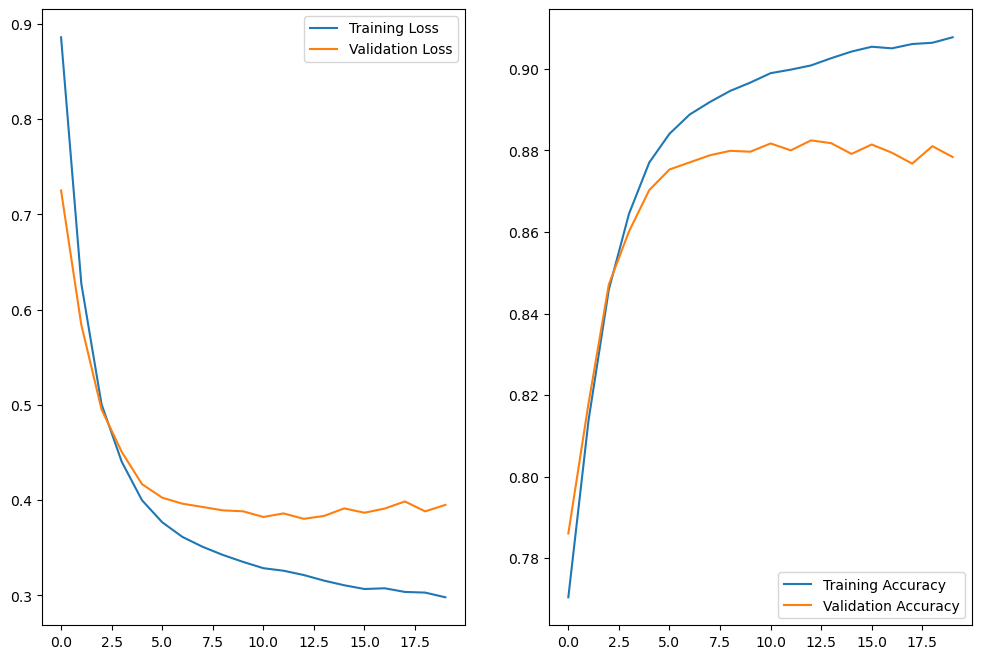

1/1 [==============================] - 0s 27ms/step
183
(358, 96, 128, 23)
(96, 128, 23)
1
0
0.39069930366847827
0.4879071200356113
110421


In [256]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Predict on train, val and test
preds_train = unet.predict(x_train, verbose=1)
preds_val = unet.predict(x_val, verbose=1)
preds_test1 = unet.predict(np.expand_dims(test_image1, 0), verbose=1)
preds_test2 = unet.predict(np.expand_dims(test_image2, 0), verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test1_t = (preds_test1 > 0.5).astype(np.uint8)
preds_test2_t = (preds_test2 > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
print(ix)
print(preds_train_t.shape)
print(preds_train_t[ix].shape)
print(preds_train_t[ix].max())
print(preds_train_t[ix].min())
print(preds_train_t[ix].mean())
print(preds_train_t[ix].std())
print(preds_train_t[ix].sum())



#### Addtional plotting code - DOES NOT WORK 

In [257]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# imports
import time
from time import process_time
import numpy as np
import numpy
import scipy.io
import cv2
from tensorboard import notebook
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, recall_score, f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import resize
from skimage.color import convert_colorspace
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout

In [258]:
# def train_and_eval(model, train, train_y, test, test_y):

#     # compile the network
#     model.compile(loss='categorical_crossentropy',
#                   optimizer=keras.optimizers.Adam(),
#                   metrics=['accuracy'])
    
#     # fit the model
#     # make the batch size smaller
#     # increase the epochs number of iterations of the dataset
#     # add decay rate for epoch
#     history = model.fit(train, train_y,
#                         batch_size=16,
#                         epochs=1,
#                         validation_data=(test, test_y),
#                         verbose=False)
    

#     # plot training and validation loss and accuracy
#     fig = plt.figure(figsize=[20, 6])
#     ax = fig.add_subplot(1, 2, 1)
#     ax.plot(history.history['loss'], label="Training Loss")
#     ax.plot(history.history['val_loss'], label="Validation Loss")
#     ax.legend()

#     ax = fig.add_subplot(1, 2, 2)
#     ax.plot(history.history['accuracy'], label="Training Accuracy")
#     ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
#     ax.legend()

#     # plot confusion matrices and F1 scores
#     fig = plt.figure(figsize=[20, 8])    

#     ax = fig.add_subplot(1, 2, 1)    
#     pred = model.predict(train, verbose=False);
#     indexes = tf.argmax(pred, axis=1)
#     gt_idx = tf.argmax(train_y, axis=1)

#     confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
#     sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
#             annot=True, fmt='g', ax=ax)
#     ax.set_title('Training, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))

#     ax = fig.add_subplot(1, 2, 2)    
#     pred = model.predict(test, verbose=False);
#     indexes = tf.argmax(pred, axis=1)
#     gt_idx = tf.argmax(test_y, axis=1)

#     confusion_mtx = tf.math.confusion_matrix(gt_idx, indexes) 
#     sns.heatmap(confusion_mtx, xticklabels=range(10), yticklabels=range(10), 
#             annot=True, fmt='g', ax=ax)
#     ax.set_title('Testing, F1 Score: %f' % f1_score(gt_idx, indexes, average='weighted'))


# train_and_eval(unet, x_train, y_train, test_image1, test_label1 )


# # history = unet.fit(x=x_train, y=y_train,
# #               validation_data=(x_val, y_val),
# #               batch_size=16, epochs=10,
# #               callbacks=[model_checkpoint, model_earlyStopping, display_cb])

# # def show_predictions(x_train = x_train, y_train = y_train, num=1):
# #     #try:
# #     pred_mask = unet.predict(np.expand_dims(x_train[train_testing_id], 0))
# #     pred_mask = np.argmax(pred_mask, axis=-1)
# #     pred_mask = pred_mask[0]
# #     display([x_train[train_testing_id], y_train[train_testing_id], pred_mask])
     

ValueError: in user code:

    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/don/anaconda3/envs/cab420/lib/python3.10/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 96, 128) and (None, 96, 128, 23) are incompatible


Text(0.5, 1.0, 'Training and Validation Loss')

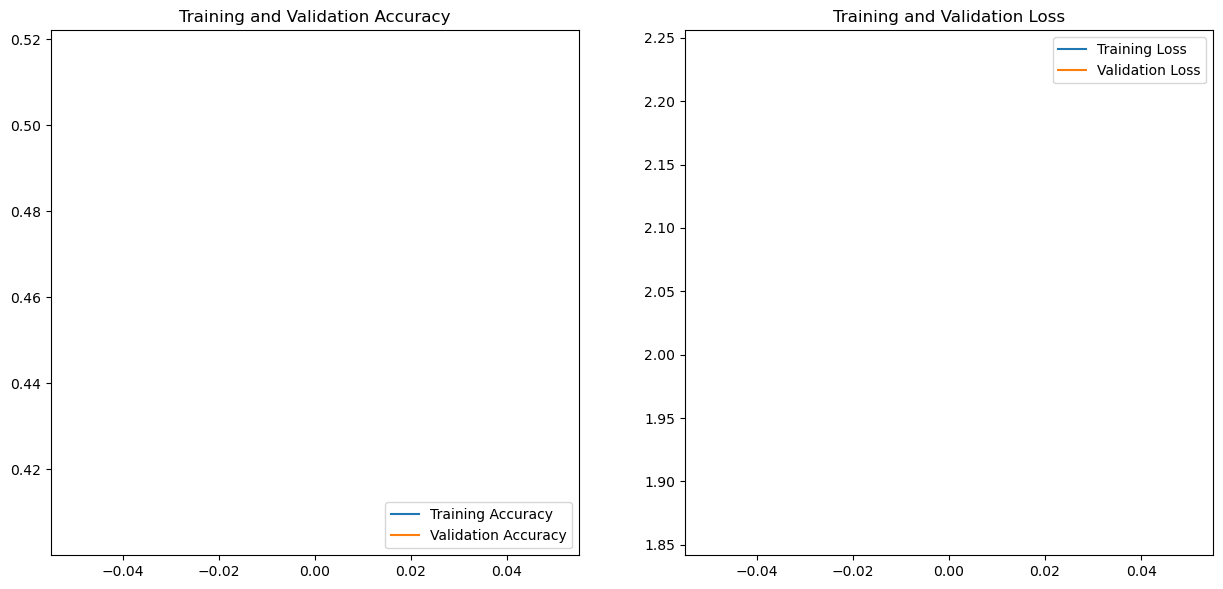

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs_range = range(len(acc))

# plt.figure(figsize=(15, 15))
# plt.subplot(2, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(2, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')

In [ ]:
# m1 = test_image1
# pred = unet.predict(np.expand_dims(m1, 0))
# pred_mask = np.argmax(pred, axis=-1)
# pred_mask = pred_mask[0]
# pred_mask_test = pred_mask
# print(pred_mask.shape)

1/1 [==============================] - 0s 32ms/step
(96, 128)


In [ ]:
# m2 = test_image2
# pred2 = unet.predict(np.expand_dims(m2, 0))

# pred_mask2 = np.argmax(pred2, axis=-1)
# pred_mask2 = pred_mask2[0]
# print(pred_mask2)

1/1 [==============================] - 0s 38ms/step
[[1 1 1 ... 1 3 1]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 ...
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 3]
 [1 1 1 ... 3 3 4]]


Text(0.5, 1.0, 'Prediction')

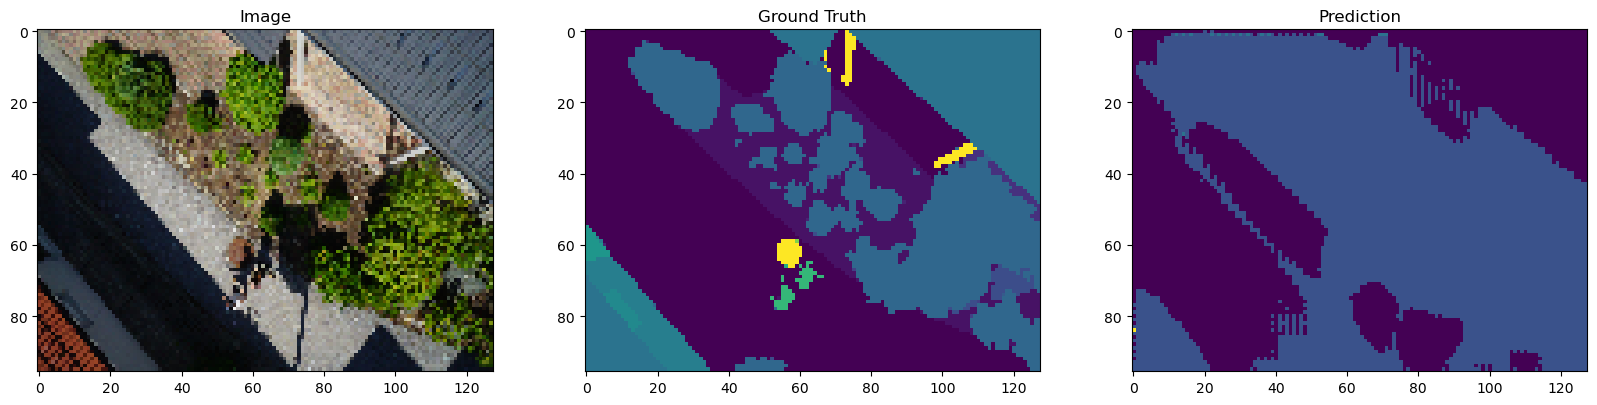

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 10))
# axs[0].imshow(m1)
# axs[0].set_title('Image')
# axs[1].imshow(test_label1)
# axs[1].set_title('Ground Truth')
# axs[2].imshow(pred_mask)
# axs[2].set_title('Prediction')

#### Visualise the labels

In [ ]:
labels = pd.read_csv('/home/don/Git/aerial-semantic-segmentation/dataset_here/class_dict_seg.csv')


labels


,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
labels = labels['name'].values
print(labels)

In [ ]:
# # Plot confusion matrix
# cm = confusion_matrix(test_label1, pred_mask)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot()

# # Plot confusion matrix
# cm = confusion_matrix(test_label2, pred_mask2)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# disp.plot()



ValueError: Classification metrics can't handle a mix of multiclass-multioutput and unknown targets

Text(0.5, 1.0, 'Prediction')

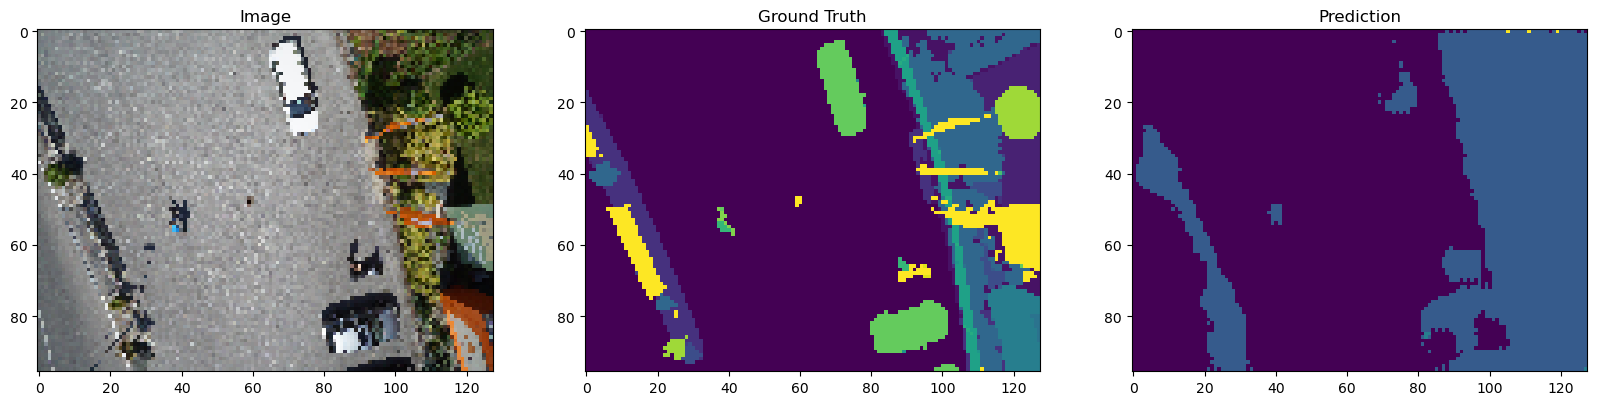

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 10))
# axs[0].imshow(m2)
# axs[0].set_title('Image')
# axs[1].imshow(test_label2)
# axs[1].set_title('Ground Truth')
# axs[2].imshow(pred_mask2)
# axs[2].set_title('Prediction')

#### Pre-trained model DID NOT USE. JUST TO SEE IF IT WORKS

In [ ]:
# new_model = tf.keras.models.load_model('unet_model.hdf5')

# # Show the model architecture
# new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 96, 128, 32)  896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 128, 32)  9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 64, 32)   0           ['conv2d_1[0][0]']           

In [ ]:
# loss, acc = new_model.evaluate(x_val, y_val, verbose=2)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

2/2 - 1s - loss: 1.8605 - accuracy: 0.5166 - 633ms/epoch - 316ms/step
Restored model, accuracy: 51.66%


In [ ]:
# new_pred = new_model.predict(np.expand_dims(m1, 0))
# new_pred = np.argmax(new_pred, axis=-1)
# new_pred = new_pred[0]

1/1 [==============================] - 0s 144ms/step


Text(0.5, 1.0, 'Prediction')

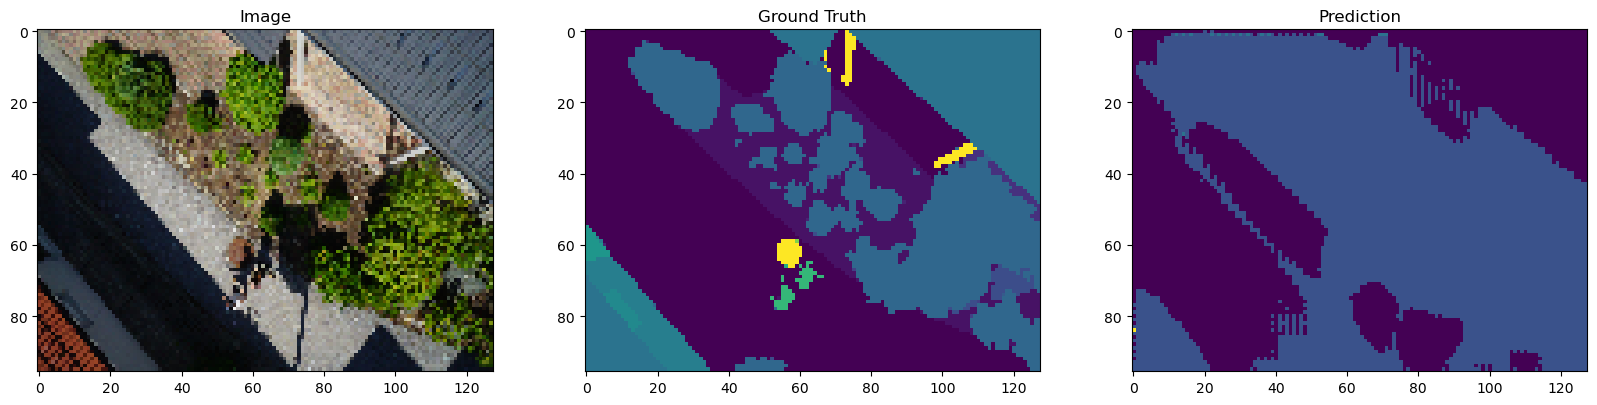

In [ ]:
# fig, axs = plt.subplots(1, 3, figsize=(20, 10))
# axs[0].imshow(m1)
# axs[0].set_title('Image')
# axs[1].imshow(test_label1)
# axs[1].set_title('Ground Truth')
# axs[2].imshow(new_pred)
# axs[2].set_title('Prediction')

In [ ]:
# print(type(new_pred))

<class 'numpy.ndarray'>


In [ ]:
# print(pred_mask.max())

9


In [ ]:
# from matplotlib import cm

# pred_mask = np.asarray(pred_mask, dtype='int32')
# pred_mask = pred_mask / 255

# pred_mask = cm.viridis(pred_mask)*255

In [ ]:
# pred_mask = np.asarray(pred_mask, dtype='uint8')

Text(0.5, 1.0, 'Prediction')

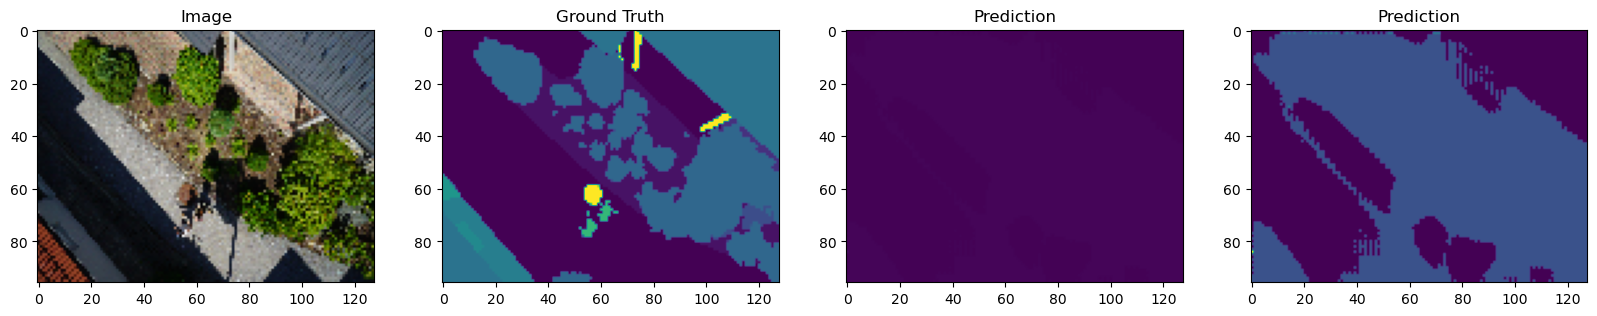

In [ ]:
# fig, axs = plt.subplots(1, 4, figsize=(20, 10))
# axs[0].imshow(m1)
# axs[0].set_title('Image')
# axs[1].imshow(test_label1)
# axs[1].set_title('Ground Truth')
# axs[2].imshow(pred_mask)
# axs[2].set_title('Prediction')
# axs[3].imshow(new_pred)
# axs[3].set_title('Prediction')

In [ ]:
# pred_mask_test = np.asarray(pred_mask_test)
# pred_mask_test = (pred_mask_test - np.min(pred_mask_test)) / (np.max(pred_mask_test) - np.min(pred_mask_test))
# pred_mask_test = cm.viridis(pred_mask_test)*255
# pred_mask_test = np.asarray(pred_mask_test, dtype='uint8')

Text(0.5, 1.0, 'Prediction')

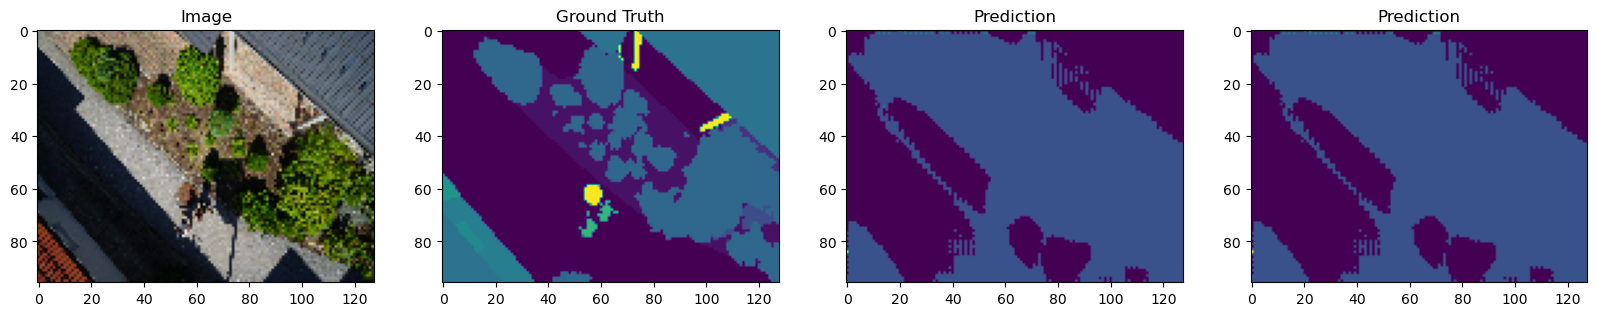

In [ ]:
# fig, axs = plt.subplots(1, 4, figsize=(20, 10))
# axs[0].imshow(m1)
# axs[0].set_title('Image')
# axs[1].imshow(test_label1)
# axs[1].set_title('Ground Truth')
# axs[2].imshow(new_pred)
# axs[2].set_title('Prediction')
# axs[3].imshow(pred_mask_test)
# axs[3].set_title('Prediction')

In [ ]:
# import matplotlib.pyplot as plt


# # a colormap and a normalization instance
# cmap = plt.cm.viridis
# norm = plt.Normalize(vmin=new_pred.min(), vmax=new_pred.max())

# # map the normalized data to colors
# # image is now RGBA (512x512x4) 
# imagened = cmap(norm(new_pred))

# # save the image
# plt.imsave('test.png', imagened)

In [ ]:
# print(imagened.min())
# print(imagened.max())

0.004874
1.0


In [ ]:
# print(pred_mask_test.min())
# print(pred_mask_test.max())

1
255


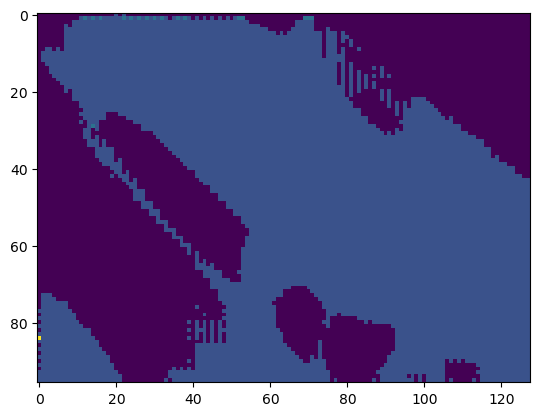

In [ ]:
# plt.imshow(imagened)

In [ ]:
# imagened = np.asarray(imagened, dtype='uint8')